In [197]:
import cv2
import numpy as np
import math
import os

In [198]:
def rotate(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background

    Source: http://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
    """
    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result

def crop_around_center(image, width, height):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point

    Source: http://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]

def largest_rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell

    Source: http://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )

def crop_largest_rectangle(image, angle, height, width):
    """
    Crop around the center the largest possible rectangle
    found with largest_rotated_rect.
    """
    return crop_around_center(
        image,
        *largest_rotated_rect(
            width,
            height,
            math.radians(angle)
        )
    )

def generate_rotated_image(image, angle, size=None, crop_center=False,
                           crop_largest_rect=False):
    """
    Generate a valid rotated image for the RotNetDataGenerator. If the
    image is rectangular, the crop_center option should be used to make
    it square. To crop out the black borders after rotation, use the
    crop_largest_rect option. To resize the final image, use the size
    option.
    """
    height, width = image.shape[:2]
    if crop_center:
        if width < height:
            height = width
        else:
            width = height

    image = rotate(image, angle)

    if crop_largest_rect:
        image = crop_largest_rectangle(image, angle, height, width)

    if size:
        image = cv2.resize(image, size)

    return image

In [199]:
import os
import numpy as np

In [200]:
def line_extractor(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # Use canny edge detection
    edges = cv2.Canny(gray,50,150,apertureSize=3)

    # Apply HoughLinesP method to 
    # to directly obtain line end points
    lines_list =[]
    lines = cv2.HoughLinesP(
                edges, # Input edge image
                1, # Distance resolution in pixels
                np.pi/180, # Angle resolution in radians
                threshold=100, # Min number of votes for valid line
                minLineLength=50, # Min allowed length of line
                maxLineGap=10 # Max allowed gap between line for joining them
                )
    
    if lines is None:
        return image
    # Convert lines to list
    lines = lines.tolist()

    for i,line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        if x1 > x2:
            lines[i][0] = [x2, y2, x1, y1]

    print(len(lines))

    i = 0
    while i < len(lines):
        x1, y1, x2, y2 = lines[i][0]
        # calculate angle vs x-axis in degrees

        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))

        # if angle is > 45 degrees or < -45 degrees
        # we classify it as an horizontal line
        if angle > 45 or angle < -45:
            # Remove horizontal lines
            lines.pop(i)
            i -= 1
        i += 1


    # Iterate over points
    for points in lines:
        # Extracted points nested in the list
        x1,y1,x2,y2=points[0]

        # Draw the lines joing the points
        # On the original image
        cv2.line(image,(x1,y1),(x2,y2),(0,255,0),2)
        # Maintain a simples lookup list for points
        lines_list.append([(x1,y1),(x2,y2)])

    return image

Running for 207_PANTRY_outside_corner.jpg
8
2


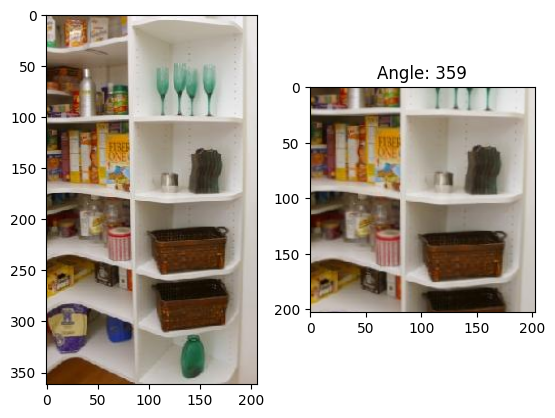

Running for cine.jpg
23
2


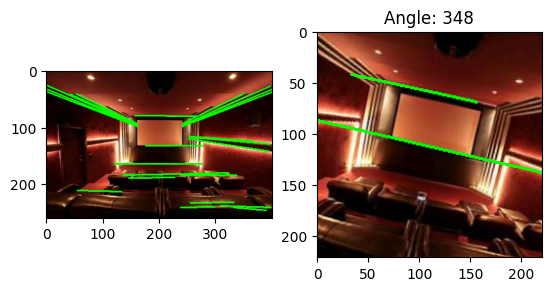

Running for warehouse_0423.jpg
588
119


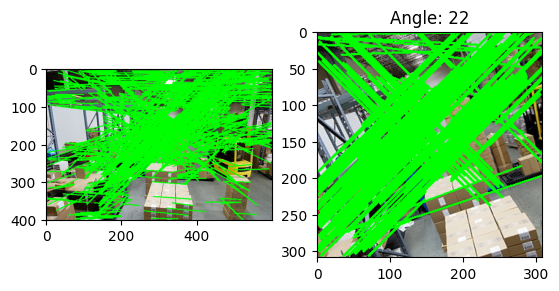

Running for inside_bus_093.jpg
223
86


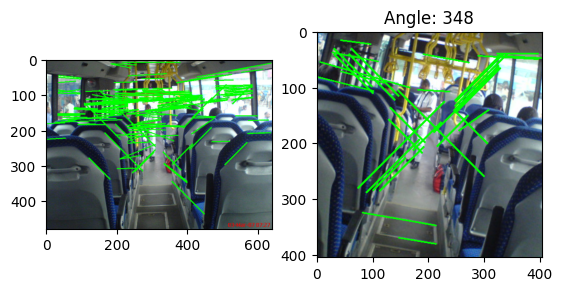

Running for subway_0450.jpg
25


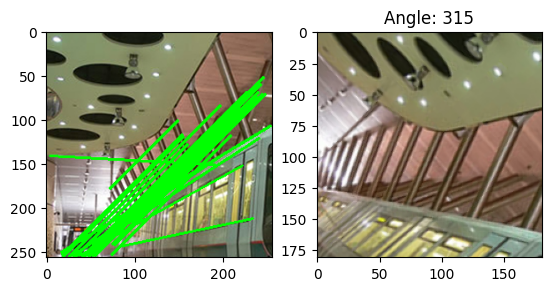

Running for subway_0493.jpg
53
16


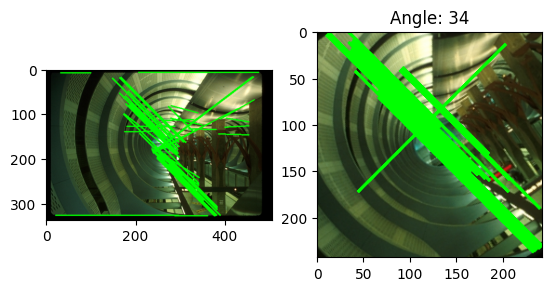

Running for subway_0254.jpg
473
96


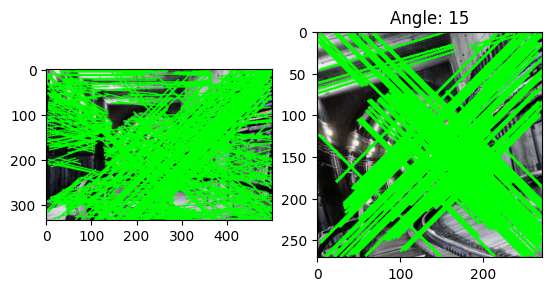

Running for inside_subway_0204.jpg
278
11


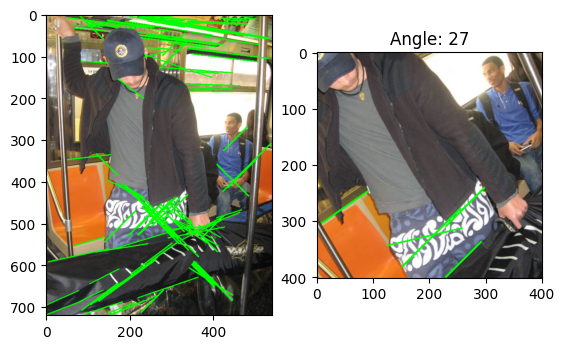

Running for casino_0290.jpg
60
3


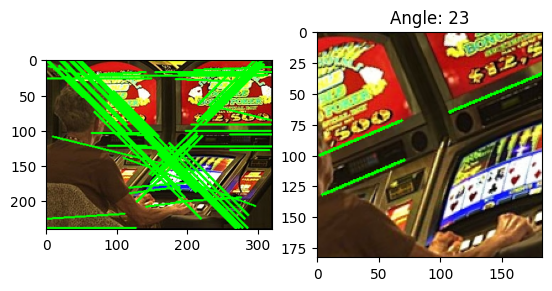

Running for 1870564269_7d37b30f88.jpg
12
4


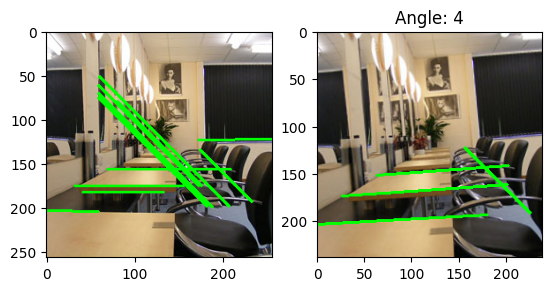

Running for wine_cellar_27_11_altavista.jpg
180
34


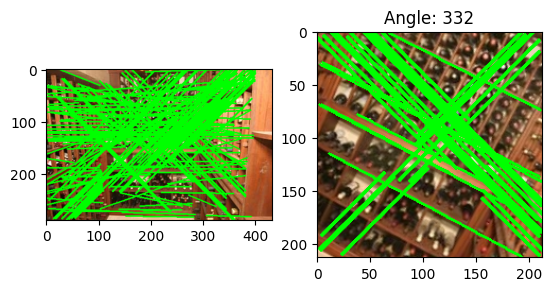

Running for bookstore_36_08_flickr.jpg
418
123


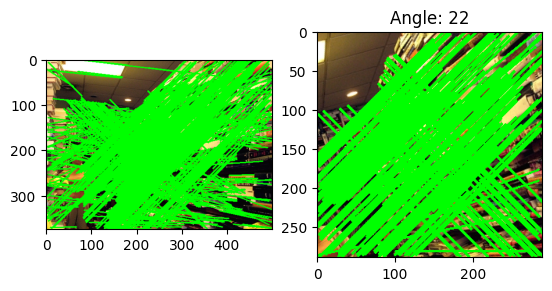

In [201]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

list_img = os.listdir('data/mit_dataset')
random.shuffle(list_img)

for i,image in enumerate(list_img):
    print(f"Running for {image}")
    # generate rotated angle from -90 to 90
    angle = np.random.randint(-45, 45)
    if angle < 0:
        angle += 360
    img = cv2.imread(f'data/mit_dataset/{image}')
    rotated_img = generate_rotated_image(
        img,
        angle,
        crop_center=True,
        crop_largest_rect=True
    )

    # Find lines in origin image and rotated image
    img_line = line_extractor(img)
    rotated_img_line = line_extractor(rotated_img)


    # Plot 2 img, 1 is original, 2 is rotated using matplotlib
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(cv2.cvtColor(img_line, cv2.COLOR_BGR2RGB))
    ax[1].imshow(cv2.cvtColor(rotated_img_line, cv2.COLOR_BGR2RGB))
    # Add title is rotate angle
    ax[1].set_title(f'Angle: {angle}')

    plt.show()
    if i > 10:
        break

In [202]:
from ultralytics import YOLO

In [205]:
# Load a COCO-pretrained YOLO11n model
model = YOLO("yolo11s.pt")

100%|██████████| 18.4M/18.4M [00:02<00:00, 7.15MB/s]


Running for ap_de_marlene035.jpg

0: 640x640 1 tv, 1 remote, 2 cell phones, 1 microwave, 11.5ms
Speed: 2.5ms preprocess, 11.5ms inference, 40.8ms postprocess per image at shape (1, 3, 640, 640)


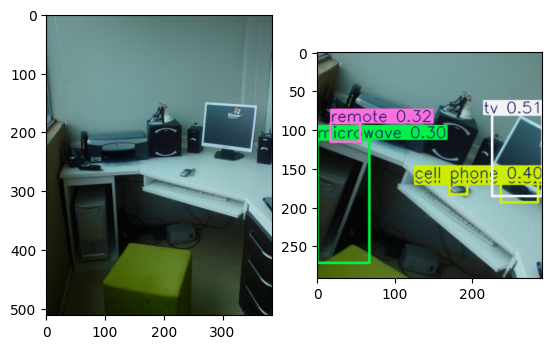

Running for cave_champagne_12_06_altavista.jpg

0: 640x640 5 persons, 15 bottles, 1 dining table, 8.5ms
Speed: 4.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


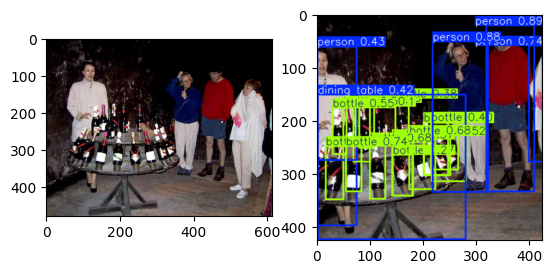

Running for CHI_011_320x400_web_large.jpg

0: 640x640 8 wine glasss, 4 chairs, 1 potted plant, 2 dining tables, 10.5ms
Speed: 6.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


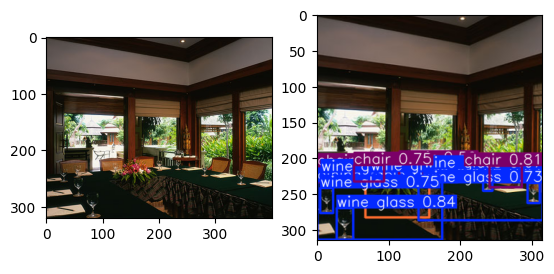

Running for DSC00525.jpg

0: 640x640 3 chairs, 1 dining table, 1 tv, 1 clock, 7.5ms
Speed: 4.5ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


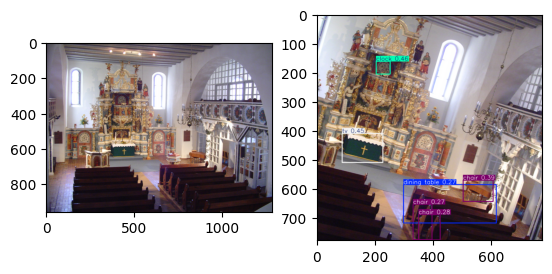

Running for galleria.jpg

0: 640x640 1 person, 1 potted plant, 1 vase, 7.6ms
Speed: 4.0ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


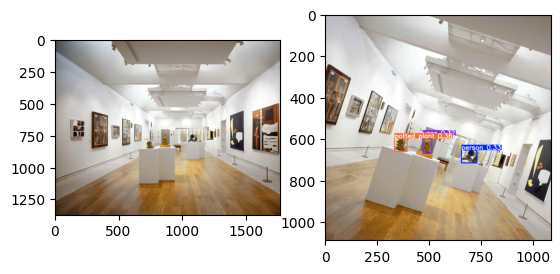

Running for southglade_gym_2.jpg

0: 640x640 4 suitcases, 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


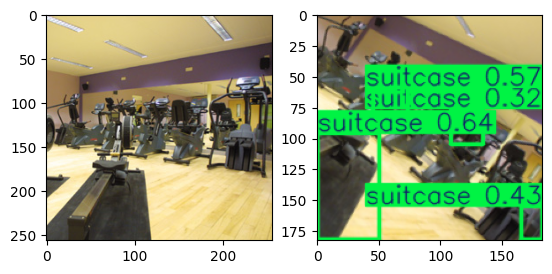

Running for computer_room.jpg

0: 640x640 2 chairs, 2 tvs, 1 keyboard, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


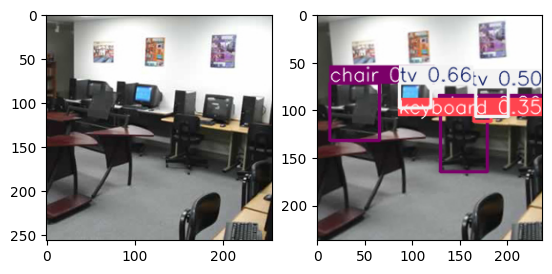

Running for whirlpool.jpg

0: 640x640 (no detections), 9.5ms
Speed: 2.0ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


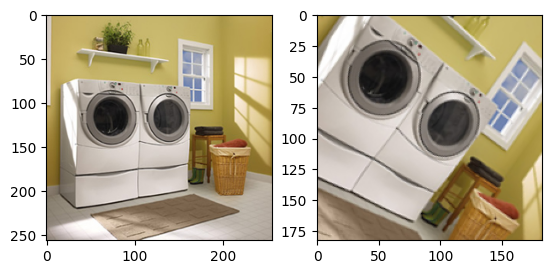

Running for locker_room_google_0170.jpg

0: 640x640 1 bus, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


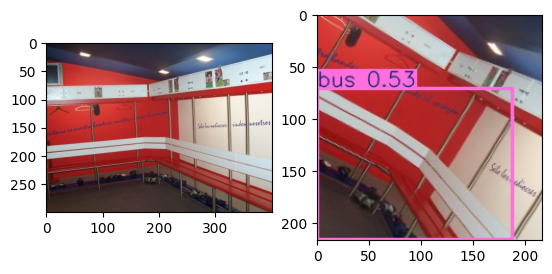

Running for PO_06_02_2000_24_l.jpg

0: 640x640 4 chairs, 3 potted plants, 2 dining tables, 1 vase, 36.5ms
Speed: 2.5ms preprocess, 36.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


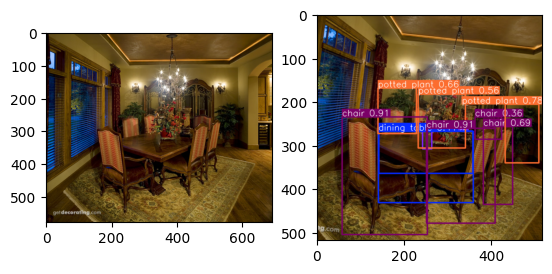

Running for panetteria_35_19_altavista.jpg

0: 640x640 2 donuts, 17.2ms
Speed: 3.0ms preprocess, 17.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


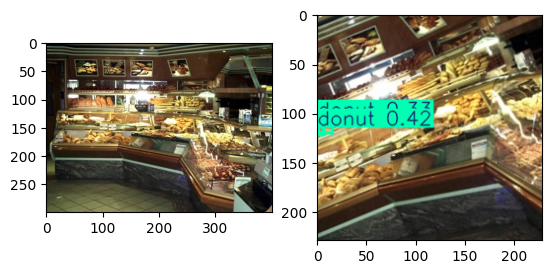

Running for POOL_INSIDE300.jpg

0: 640x640 2 persons, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


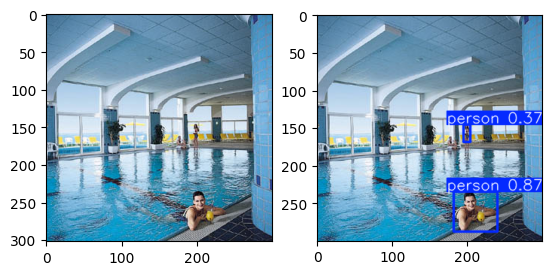

In [206]:
list_img = os.listdir('data/mit_dataset')
random.shuffle(list_img)

for i,image in enumerate(list_img):
    print(f"Running for {image}")
    # generate rotated angle from -90 to 90
    angle = np.random.randint(-45, 45)
    if angle < 0:
        angle += 360
    img = cv2.imread(f'data/mit_dataset/{image}')
    rotated_img = generate_rotated_image(
        img,
        angle,
        crop_center=True,
        crop_largest_rect=True
    )

    result = model.predict(rotated_img)
    result_plot = result[0].plot()

    # Plot 2 img, 1 is original, 2 is rotated using matplotlib
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[1].imshow(cv2.cvtColor(result_plot, cv2.COLOR_BGR2RGB))

    plt.show()
    if i > 10:
        break